In [1]:
import json
import pandas as pd
import copy
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, LassoCV, ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [2]:
doc = json.load(open('spot-advisor-data.json'))
prices_pd = pd.read_csv('data.csv')[['instanceType', 'Region', 'OS', 'Price']].drop_duplicates(subset=['instanceType', 'Region', 'OS'], keep='last')

In [3]:
prices_pd

,instanceType,Region,OS,Price
8938664,a1.medium,us-east,linux,0.0084
8938665,a1.large,us-east,linux,0.0217
8938666,a1.xlarge,us-east,linux,0.0341
8938667,a1.2xlarge,us-east,linux,0.0671
8938668,a1.4xlarge,us-east,linux,0.1343
...,...,...,...,...
8948957,m5d.metal,eu-south-1,mswin,5.9431
8948958,r5.metal,eu-south-1,linux,1.5998
8948959,r5.metal,eu-south-1,mswin,6.0158
8948960,r5d.metal,eu-south-1,linux,1.5998


In [4]:
price_by_machine = {}
def func(r):
    os = 'Windows' if r['OS'] == 'mswin' else 'Linux'
    price_by_machine[(r['instanceType'], r['Region'], os)] = r['Price']
_ = prices_pd.apply(func, axis=1)
price_by_machine

{('a1.medium', 'us-east', 'Linux'): 0.0084,
 ('a1.large', 'us-east', 'Linux'): 0.0217,
 ('a1.xlarge', 'us-east', 'Linux'): 0.0341,
 ('a1.2xlarge', 'us-east', 'Linux'): 0.0671,
 ('a1.4xlarge', 'us-east', 'Linux'): 0.1343,
 ('a1.metal', 'us-east', 'Linux'): 0.1343,
 ('t2.micro', 'us-east', 'Linux'): 0.0035,
 ('t2.micro', 'us-east', 'Windows'): 0.0081,
 ('t2.small', 'us-east', 'Linux'): 0.0069,
 ('t2.small', 'us-east', 'Windows'): 0.0159,
 ('t2.medium', 'us-east', 'Linux'): 0.0139,
 ('t2.medium', 'us-east', 'Windows'): 0.0319,
 ('t2.large', 'us-east', 'Linux'): 0.0278,
 ('t2.large', 'us-east', 'Windows'): 0.0558,
 ('t2.xlarge', 'us-east', 'Linux'): 0.0557,
 ('t2.xlarge', 'us-east', 'Windows'): 0.0967,
 ('t2.2xlarge', 'us-east', 'Linux'): 0.1114,
 ('t2.2xlarge', 'us-east', 'Windows'): 0.1734,
 ('t3.nano', 'us-east', 'Linux'): 0.0016,
 ('t3.nano', 'us-east', 'Windows'): 0.0062,
 ('t3.micro', 'us-east', 'Linux'): 0.0031,
 ('t3.micro', 'us-east', 'Windows'): 0.0123,
 ('t3.small', 'us-east', '

In [5]:
class OneHotEncoderTransformer(BaseEstimator, TransformerMixin):
    """
    Apply one hot encoding to each category feature.
    This transformer returns `DataFrame` instead of default `numpy.ndarray`
    """

    def __init__(self):
        # self.ohe = OneHotEncoder(sparse=False, drop='first')
        self.ohe = OneHotEncoder(sparse=False)

    def fit(self, X, y=None):
        X_ = X.select_dtypes(include='category')
        self.ohe.fit(X_, y)
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        X_cat = X.select_dtypes(include='category')
        X_ohe = pd.DataFrame(self.ohe.transform(X_cat), columns=self.ohe.get_feature_names(X_cat.columns), index=X_.index)
        X_ = pd.concat([X_.drop(columns=X_cat.columns), X_ohe], axis=1)
        return X_

In [6]:
def get_X_y():
    l = []
    for region in doc['spot_advisor']:
        subdoc = doc['spot_advisor'][region]
        for os in subdoc:
            subsubdoc = subdoc[os]
            for instanceType in subsubdoc:
                subsubsubdoc = subsubdoc[instanceType]
                row = copy.deepcopy(subsubsubdoc)
                row['region'] = region
                row['os'] = os
                row['instanceType'] = instanceType
                for attr in doc['instance_types'][instanceType]:
                    row[attr] = doc['instance_types'][instanceType][attr]
                row['major'], row['minor'] = row['instanceType'].split('.')
                try:
                    row['price'] = price_by_machine[(instanceType, region, os)]
                    row['no_price'] = 0
                except KeyError:
                    row['price'] = 0
                    row['no_price'] = 1
                l.append(row)
    data = pd.DataFrame(l)

    data = data.astype({
        's': int,
        'region': 'category',
        'os': 'category',
        'instanceType': 'category',
        'ram_gb': int,
        'emr': bool,
        'cores': int,
        'major': 'category',
        'minor': 'category',
        'price': int,
        'no_price': int,
    })

    X, y = data.drop(columns=['r', 'instanceType']), data['r']
    return train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
def create_pipeline():
    return Pipeline([
        ('ohe', OneHotEncoderTransformer()),
        ('linear', LinearRegression()),
        # ('logistic', LogisticRegression(multi_class='multinomial')),
    ]), Pipeline([
        ('ohe', OneHotEncoderTransformer()),
        ('ridge', Ridge()),
    ]), Pipeline([
        ('ohe', OneHotEncoderTransformer()),
        ('lasso', Lasso()),
    ]), Pipeline([
        ('ohe', OneHotEncoderTransformer()),
        ('lasso_cv', LassoCV()),
    ]), Pipeline([
        ('ohe', OneHotEncoderTransformer()),
        ('elasticnet_cv', ElasticNetCV()),
    ]), Pipeline([
        ('ohe', OneHotEncoderTransformer()),
        ('lasso_alpha001', Lasso(alpha=0.01)),
    ]), Pipeline([
        ('ohe', OneHotEncoderTransformer()),
        ('lasso_alpha0003', Lasso(alpha=0.003)),
    ]), Pipeline([
        ('ohe', OneHotEncoderTransformer()),
        ('lasso_alpha0001', Lasso(alpha=0.001)),
    ]), Pipeline([
        ('ohe', OneHotEncoderTransformer()),
        ('lasso_alpha00001', Lasso(alpha=0.0001)),
    ]), Pipeline([
        ('ohe', OneHotEncoderTransformer()),
        ('mlp', MLPRegressor()),
    ]) , Pipeline([
        ('ohe', OneHotEncoderTransformer()),
        ('random_forest', RandomForestRegressor()),
    ])

In [8]:
X_train, X_test, y_train, y_test = get_X_y()

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7295 entries, 5156 to 7270
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   s         7295 non-null   int64   
 1   region    7295 non-null   category
 2   os        7295 non-null   category
 3   ram_gb    7295 non-null   int64   
 4   emr       7295 non-null   bool    
 5   cores     7295 non-null   int64   
 6   major     7295 non-null   category
 7   minor     7295 non-null   category
 8   price     7295 non-null   int64   
 9   no_price  7295 non-null   int64   
dtypes: bool(1), category(4), int64(5)
memory usage: 381.7 KB


In [10]:
linear, ridge, lasso, lasso_cv, elasticnet_cv, lasso_alpha001, lasso_alpha0003, lasso_alpha0001, lasso_alpha00001, mlp, random_forest = create_pipeline()
models = {
    'linear': linear,
    'ridge': ridge,
    'lasso': lasso,
    'lasso_cv': lasso_cv,
    'elasticnet_cv': elasticnet_cv,
    'lasso_alpha001': lasso_alpha001,
    'lasso_alpha0003': lasso_alpha0003,
    'lasso_alpha0001': lasso_alpha0001,
    'lasso_alpha00001': lasso_alpha00001,
    'mlp': mlp,
    'random_forest': random_forest,
}

In [11]:
for model in models:
    models[model].fit(X_train, y_train)

/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureW

In [12]:
rmse = {}
for model in models:
    rmse[model] = np.sqrt(np.sum((models[model].predict(X_test) - y_test)**2)/len(y_test)) # RMSE
rmse

/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureW

{'linear': 1.0785121326728202,
 'ridge': 1.0790781894948775,
 'lasso': 1.4416469472298223,
 'lasso_cv': 1.4420706177030185,
 'elasticnet_cv': 1.4420698827014133,
 'lasso_alpha001': 1.2331999469315282,
 'lasso_alpha0003': 1.1168745283773474,
 'lasso_alpha0001': 1.0875050681241427,
 'lasso_alpha00001': 1.0789353572601112,
 'mlp': 1.0210358263430657,
 'random_forest': 0.9641096128428343}

In [13]:
mad = {}
for model in models:
    mad[model] = np.sum(np.abs(models[model].predict(X_test) - y_test))/len(y_test) # MAD
mad

/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureW

{'linear': 0.8214232599414908,
 'ridge': 0.8236072679791809,
 'lasso': 1.2485007821691003,
 'lasso_cv': 1.2483365314838233,
 'elasticnet_cv': 1.2483366180703397,
 'lasso_alpha001': 1.0374963333612515,
 'lasso_alpha0003': 0.8904507808598051,
 'lasso_alpha0001': 0.8394849308554634,
 'lasso_alpha00001': 0.8223579502817777,
 'mlp': 0.762729035508768,
 'random_forest': 0.6821202003338898}

In [14]:
mad_rounded = {}
for model in models:
    mad_rounded[model] = np.sum(np.abs(np.round(models[model].predict(X_test)) - y_test))/len(y_test) # MAD rounded
mad_rounded

/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureW

{'linear': 0.7743461324429605,
 'ridge': 0.7762938230383973,
 'lasso': 1.3074568725653868,
 'lasso_cv': 1.2843628269337786,
 'elasticnet_cv': 1.2843628269337786,
 'lasso_alpha001': 1.0022259321090707,
 'lasso_alpha0003': 0.8291597106288259,
 'lasso_alpha0001': 0.7877017250973846,
 'lasso_alpha00001': 0.7774067890929327,
 'mlp': 0.7153589315525877,
 'random_forest': 0.6466332776850306}

In [15]:
def get_coefs_sorted(model_name):
    df = pd.DataFrame(models[model_name][model_name].coef_, columns=['coef'])
    df['feature'] = models[model_name][model_name].feature_names_in_
    df['coef_abs'] = np.abs(df['coef'])
    return df.sort_values('coef_abs', ascending=False)

In [16]:
get_coefs_sorted('linear')

,coef,feature,coef_abs
45,-2.316148,major_dl1,2.316148
54,2.244741,major_h1,2.244741
77,2.218962,major_p3,2.218962
55,2.162922,major_i2,2.162922
76,2.133260,major_p2,2.133260
...,...,...,...
0,0.008624,s,0.008624
3,0.006780,cores,0.006780
113,-0.003802,minor_8xlarge,0.003802
1,0.000098,ram_gb,0.000098


In [17]:
get_coefs_sorted('ridge')

,coef,feature,coef_abs
77,2.130140,major_p3,2.130140
54,2.125731,major_h1,2.125731
55,2.100086,major_i2,2.100086
76,2.052036,major_p2,2.052036
48,2.015328,major_g3,2.015328
...,...,...,...
3,0.005601,cores,0.005601
19,0.004674,region_eu-west-2,0.004674
11,-0.002414,region_ap-south-1,0.002414
106,-0.001695,minor_24xlarge,0.001695


In [18]:
get_coefs_sorted('lasso')

,coef,feature,coef_abs
3,-0.002248,cores,0.002248
1,0.000989,ram_gb,0.000989
0,0.000825,s,0.000825
120,-0.000000,minor_small,0.000000
76,0.000000,major_p2,0.000000
...,...,...,...
36,-0.000000,major_c5d,0.000000
35,-0.000000,major_c5ad,0.000000
34,-0.000000,major_c5a,0.000000
33,-0.000000,major_c5,0.000000


In [19]:
get_coefs_sorted('lasso_cv')

,coef,feature,coef_abs
0,0.004356,s,0.004356
3,-0.003503,cores,0.003503
1,0.001089,ram_gb,0.001089
120,-0.000000,minor_small,0.000000
76,0.000000,major_p2,0.000000
...,...,...,...
36,-0.000000,major_c5d,0.000000
35,-0.000000,major_c5ad,0.000000
34,-0.000000,major_c5a,0.000000
33,-0.000000,major_c5,0.000000


In [20]:
get_coefs_sorted('lasso_alpha001')

,coef,feature,coef_abs
56,1.934927,major_i3,1.934927
101,1.871637,major_z1d,1.871637
42,1.516010,major_d2,1.516010
55,1.038520,major_i2,1.038520
59,1.032144,major_inf1,1.032144
...,...,...,...
19,-0.000000,region_eu-west-2,0.000000
58,-0.000000,major_im4gn,0.000000
20,-0.000000,region_eu-west-3,0.000000
21,0.000000,region_me-south-1,0.000000


In [21]:
get_coefs_sorted('lasso_alpha0003')

,coef,feature,coef_abs
101,2.394714,major_z1d,2.394714
56,2.358010,major_i3,2.358010
42,2.189435,major_d2,2.189435
55,2.145500,major_i2,2.145500
59,2.104218,major_inf1,2.104218
...,...,...,...
41,0.000000,major_c6i,0.000000
91,-0.000000,major_r6i,0.000000
92,0.000000,major_t1,0.000000
32,0.000000,major_c4,0.000000


In [22]:
get_coefs_sorted('lasso_alpha0001')

,coef,feature,coef_abs
101,2.537284,major_z1d,2.537284
55,2.510167,major_i2,2.510167
56,2.468180,major_i3,2.468180
77,2.466277,major_p3,2.466277
48,2.419182,major_g3,2.419182
...,...,...,...
11,-0.000000,region_ap-south-1,0.000000
100,0.000000,major_x2gd,0.000000
93,-0.000000,major_t2,0.000000
97,0.000000,major_vt1,0.000000


In [23]:
get_coefs_sorted('lasso_alpha00001')

,coef,feature,coef_abs
54,2.803746,major_h1,2.803746
77,2.787979,major_p3,2.787979
55,2.741916,major_i2,2.741916
76,2.705546,major_p2,2.705546
61,2.668478,major_m1,2.668478
...,...,...,...
11,0.000000,region_ap-south-1,0.000000
114,0.000000,minor_9xlarge,0.000000
116,-0.000000,minor_medium,0.000000
28,0.000000,os_Windows,0.000000


# Most important features for interruptions

In [24]:
df = get_coefs_sorted('lasso_alpha0003')
len(df[df.coef_abs > 0.0001]), len(df)

(74, 122)

<AxesSubplot:xlabel='feature'>

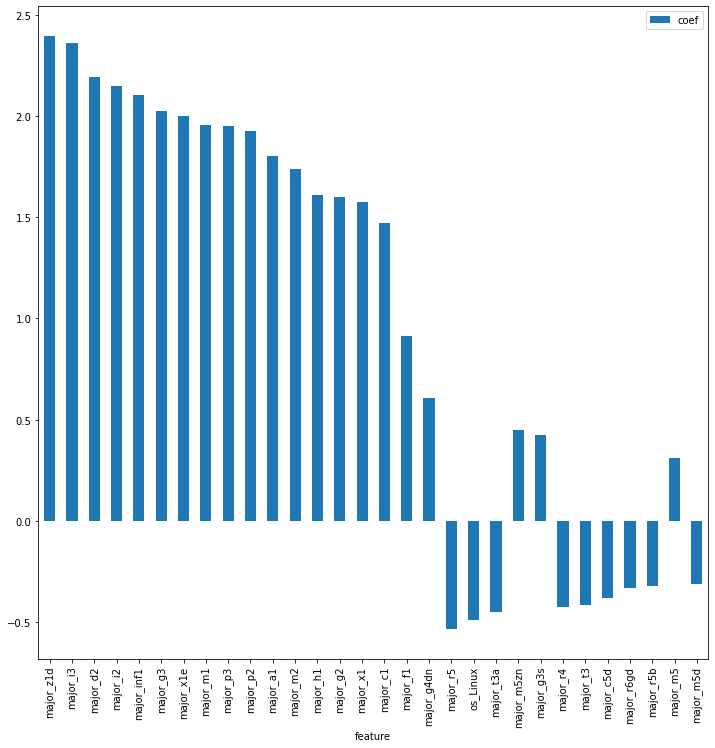

In [25]:
lasso_alpha0003_df = get_coefs_sorted('lasso_alpha0003')
lasso_alpha0003_df.take(range(30)).plot(x='feature', y='coef', kind='bar', figsize=(12,12))

<AxesSubplot:xlabel='feature'>

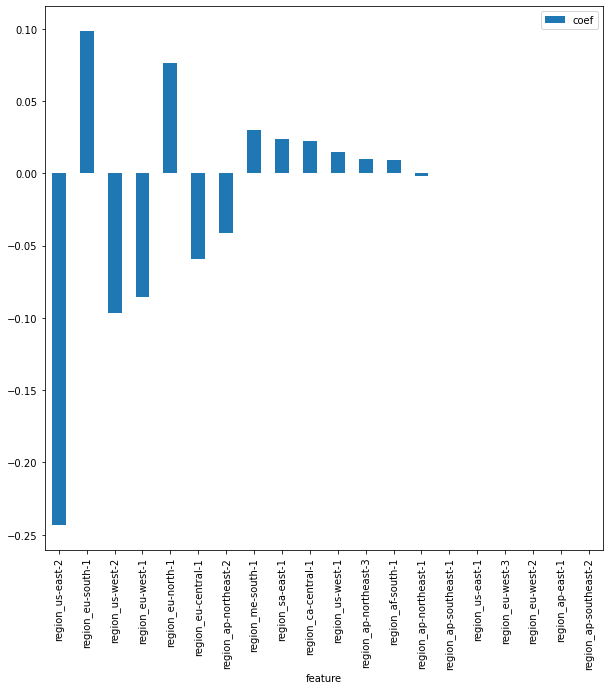

In [26]:
lasso_alpha0003_df[lasso_alpha0003_df.feature.apply(lambda f: 'region' in f)].take(range(20)).plot(x='feature', y='coef', kind='bar', figsize=(10,10))

<AxesSubplot:xlabel='feature'>

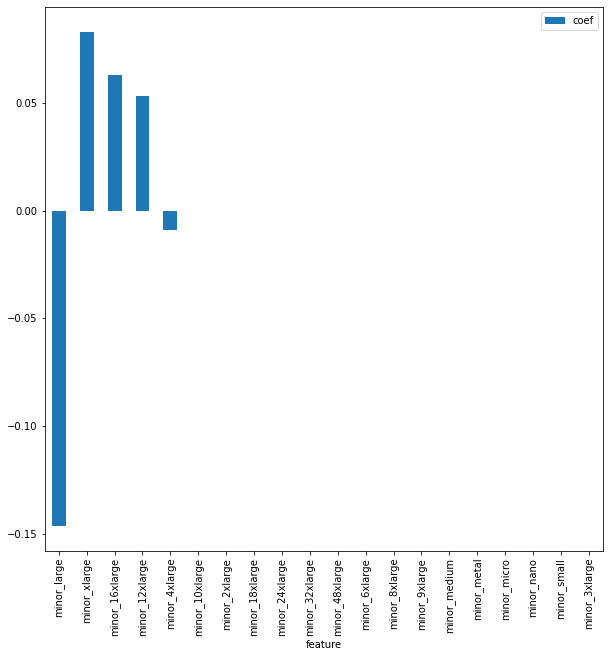

In [27]:
lasso_alpha0003_df[lasso_alpha0003_df.feature.apply(lambda f: 'minor' in f)].take(range(20)).plot(x='feature', y='coef', kind='bar', figsize=(10,10))

<AxesSubplot:xlabel='feature'>

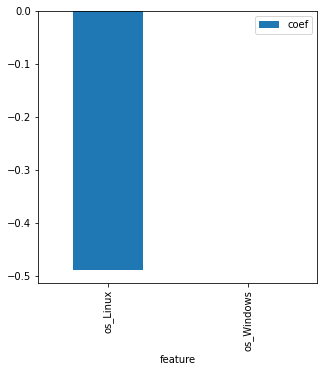

In [28]:
lasso_alpha0003_df[lasso_alpha0003_df.feature.apply(lambda f: 'os' in f)].plot(x='feature', y='coef', kind='bar', figsize=(5,5))

# Variance of predictions

In [29]:
vars = {}
vars['ground_truth'] = np.var(y_test)
for model in models:
    vars[model] = np.var(models[model].predict(X_test))

vars_df = pd.DataFrame()
vars_df['model'], vars_df['var'] = zip(*vars.items())
vars_df

/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureW

,model,var
0,ground_truth,2.163094
1,linear,1.016711
2,ridge,0.984692
3,lasso,0.066735
4,lasso_cv,0.078303
5,elasticnet_cv,0.078298
6,lasso_alpha001,0.351645
7,lasso_alpha0003,0.685913
8,lasso_alpha0001,0.876420
9,lasso_alpha00001,0.999813


<AxesSubplot:>

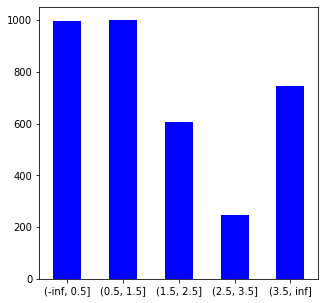

In [30]:
bins = np.arange(-0.5, 4.51, 1)
bins[0] = -np.inf
bins[-1] = np.inf
# Plot ground truth hist
pd.cut(y_test, bins=bins, include_lowest=True).value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(5,5))

/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


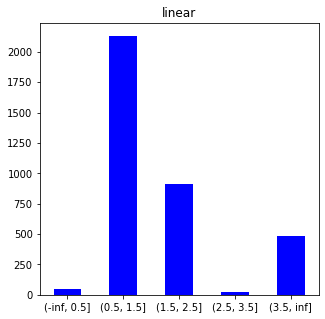

/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


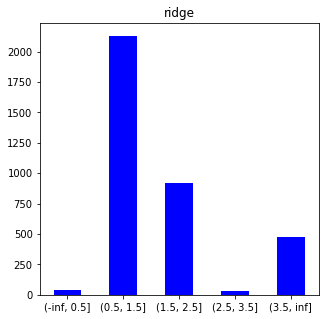

/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


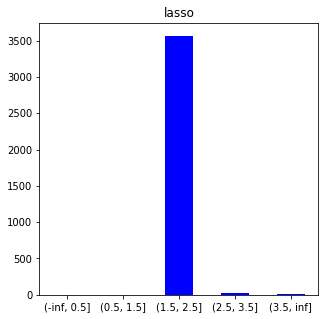

/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


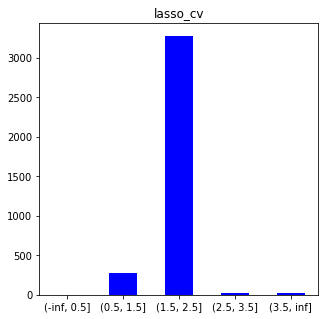

/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


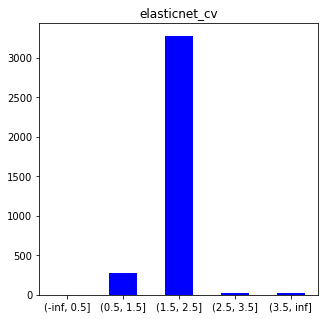

/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


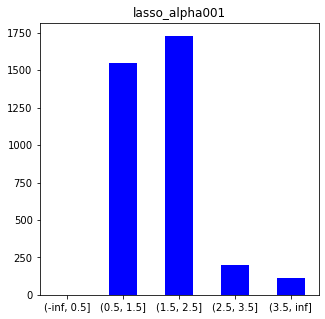

/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


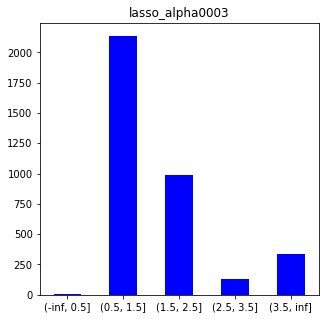

/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


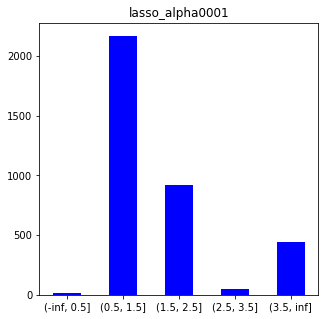

/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


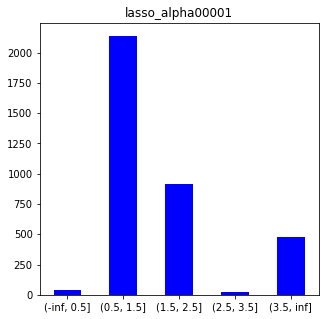

/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


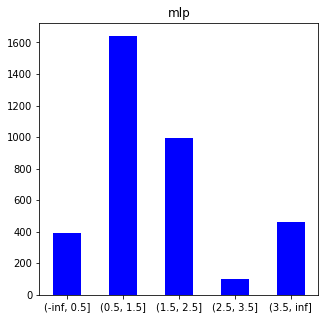

/opt/anaconda3/envs/untitled/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


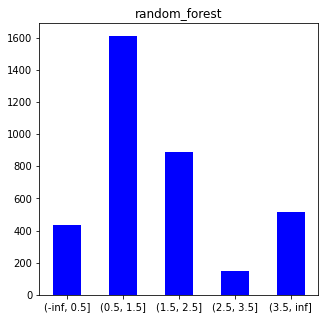

In [31]:
for model in models:
    pd.cut(pd.Series(models[model].predict(X_test)), bins=bins, include_lowest=True).value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(5,5), title=model)
    plt.show()

In [32]:
rf_importances_df = pd.DataFrame()
rf_importances_df['feature_name'], rf_importances_df['feature_importance'] = random_forest[1].feature_names_in_, random_forest[1].feature_importances_
rf_importances_df

,feature_name,feature_importance
0,s,0.109143
1,ram_gb,0.048570
2,emr,0.008926
3,cores,0.035604
4,price,0.009694
...,...,...
117,minor_metal,0.006623
118,minor_micro,0.001058
119,minor_nano,0.000965
120,minor_small,0.001282


<AxesSubplot:xlabel='feature_name'>

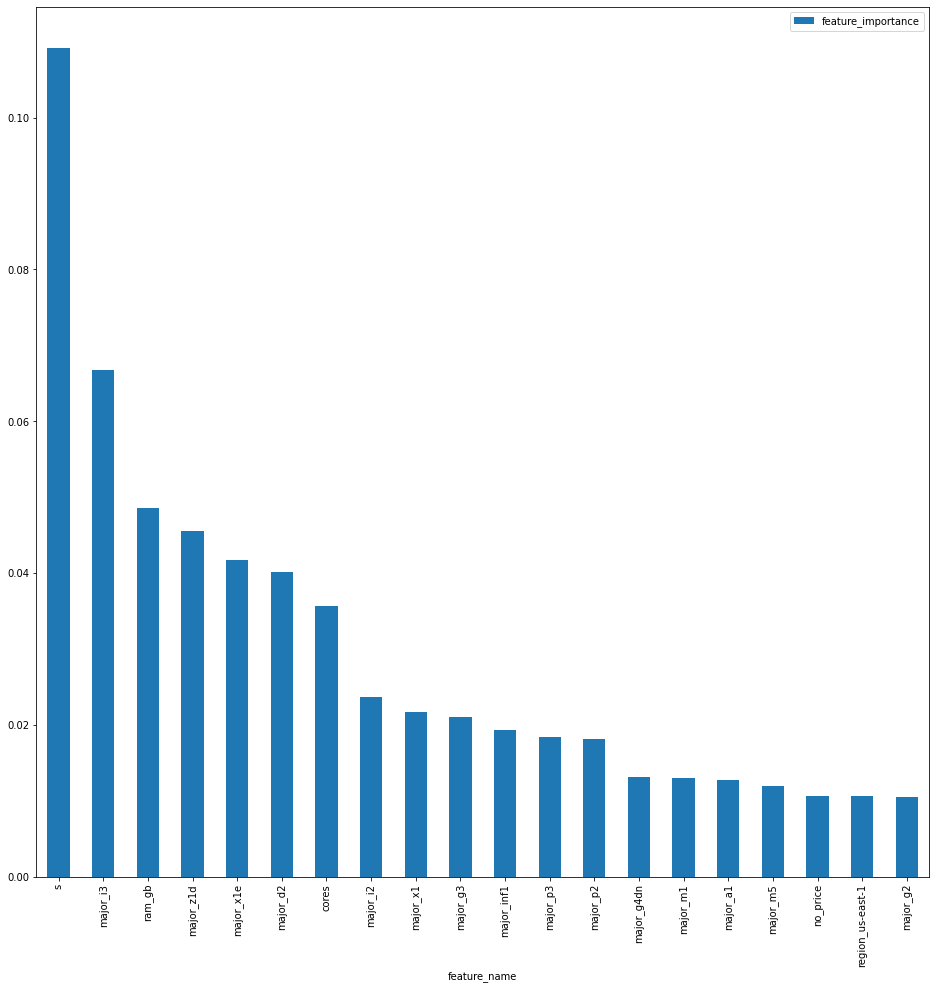

In [33]:
rf_importances_df.sort_values(by='feature_importance', ascending=False).take(range(20)).plot(x='feature_name', y='feature_importance', kind='bar', figsize=(16,16))
# rf_importances_df.sort_values(by='feature_importance')

<AxesSubplot:xlabel='s', ylabel='ram_gb'>

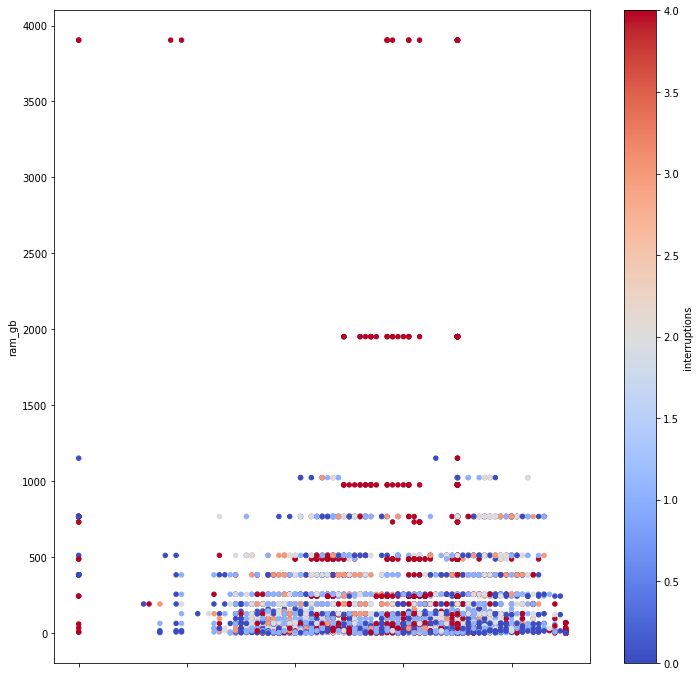

In [48]:
df = X_train.copy()
df['interruptions'] = y_train
df.plot.scatter(x='s', y='ram_gb', c='interruptions', colormap='coolwarm', figsize=(12,12))